# Initialisation

Le code ci-après a été extrait d'un code source plus complexe gérant une multitude de bibliothèques NLP et de modèles, qui a permis de tester de nombreux scénarios et qui a conduit à produire le meilleur résultat obtenu par le groupe pour les modèles MultinomialNB, LogisticRegression et SVM.
Le code proposé ci-après est fonctionnel et centré sur ces 3 modèles, avec les meilleurs hyperparamètres trouvés pour chacun d'eux.

## Environnement, bibliothèques, local settings

In [ ]:
Env = 'local'   # exécution sur PC local
Env = ''        # exécution sur Google Colab

!pip install langdetect

# -- La base
import pandas as pd
import numpy as np

# -- DataViz
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
%matplotlib inline

# -- OS
import os
if Env !='local':
    from google.colab import drive
import shutil
import zipfile

# !pip install tqdm
# !pip install imblearn

# # -- Divers
# from tqdm import tqdm
# import time

# ---- Chemins d'accès
RootPath = ''
if Env !='local':
    drive.mount('/content/drive')                                                   # Je monte mon drive
    RootPath = '/content/drive/MyDrive/Formation/Projet/Colab Notebooks/dbd/'       # Root
    RootColabPath = '/content/'

    ImgArcFullSrcPath = '/content/drive/MyDrive/Formation/Projet/images.zip'
    ImgArcFullDstPath = '/content/images.zip'
    ImgTrainPath = RootColabPath + 'images/image_train/'
    ImgTestPath = RootColabPath + 'images/image_test/'
else:
    RootPath = 'C:/Users/dball/Documents/Formation/Projet/Rakuten/'


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 9.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=663b387a5fb9a23e0b8f861486be4a0cf150dbee8c0ec6c137850fa47c45ca06
  Stored in directory: /root/.cache/pip/wheels/0a/f2/b2/e5ca405801e05eb7c8ed5b3b4bcf1fcabcd6272c167640072e
Successfully built langdetect
Mounted at /content/drive


In [ ]:
# ---- Chargement des bibliothèques

# -- NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from functools import reduce
import re
from langdetect import detect   # algo détection langue Google

# -- Vectorisation
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import save_npz, load_npz

# -- Modelisation
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, ParameterGrid
from sklearn.preprocessing import LabelEncoder

# -- Evaluation
from sklearn.metrics import f1_score, classification_report, confusion_matrix

# -- Autres
import joblib
from time import time


nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')


# # -- Chargement du dictionnaire des mots vides de sens
sw = stopwords.words("french")
sw.extend(["nbsp","amp","gt","lt","cm","mm","m²","m³","kg","gr","gb","N°","ø"])     # que l'on enrichit avec les mots parasites repérés à l'aide des wordcloud (étape DataViz)

# -- Chargement du dictionnaire d'expressions vides de sens, fortement représentés mais apparaissant davantage comme du bruit pour discriminer la classe
sx = ["haute qualité","durée de vie","légère déviation","taille du produit","dimension extérieure","dimension intérieure"
                      ,"dimensions extérieures","dimensions intérieures"
]

# -- Divers
accents = {"eacute":"é", "egrave":"è", "ecirc":"ê", "agrave":"à", "ccedil":"ç", "Acirc":"â", "rsquo":"'"}


# Pre-processing

## Préparation du set

### Mise en forme

In [ ]:
# -------------- Mise en forme des variables et observations

# On reconstitue le set complet au sein d'un dataframe car initialement fourni de manière séparé (feature / target)
X_train_Init = pd.read_csv(RootPath + 'X_train_update.csv', sep=',', index_col=0)
Y_train_Init = pd.read_csv(RootPath + 'Y_train_CVw08PX.csv', sep=',', index_col=0)
df = pd.merge(X_train_Init, Y_train_Init, left_on = X_train_Init.index, right_on = Y_train_Init.index).iloc[:,-5:].reset_index(drop=True)

# On réunit les variables textuelles designation et description pour maximiser l'information utile
df['text'] = df['designation']+'. '+df['description'].fillna('')

# On enrichit le set avec la détection de la langue
df['langue'] = df['text'].apply(lambda x: detect(x))    # /!\ runtime 5-10 mn

# On choisit de ne garder que les observations rédigées en français (+ des 3/4 du set), ayant établi que,
# dans le cadre de modèles ML, conserver les observations rédigées dans d'autres langues nuit aux performances
# En outre, les bibliothèques de NLP utilisées par la suite seront centrées sur le dictionnaire en français
df.drop(df[df['langue']!='fr'].index, axis=0, inplace=True)
df.drop(['designation', 'description', 'langue'], axis=1, inplace=True)
df = df.reset_index(drop=True)

df.to_csv(RootPath + 'BestML1_set_raw.csv', index=False)

### Nettoyage et synthèse

In [ ]:
# -------------- Nettoyage et synthèse du texte

def cleaning(text):

    text = text.lower()

    # -- Restauration des accents
    cles = list(accents.keys())
    text = reduce(lambda t, i: t.replace('&'+cles[i]+';', list(accents.values())[i]), range(len(cles)), text)   # on restitue les accents à partir de leur encodage html

    # -- Nettoyage caractères indésirables
    text = re.sub(r"<.*?>", " ", text)                          # balises html
    text = re.sub(r"\S*\d\S*", " ", text)                       # mots contenant au moins un chiffre
    text = re.sub(r"\W+", " ", text)                            # ponctuation et caractères spéciaux
    text = re.sub(r"\b[a-zA-Z]\b", " ", text)                   # lettres isolées (bien mettre après les 2 précédents nettoyages)

    # -- Suppression des expressions vides de sens
    for expr in sx:
        text = re.sub(r"\b" + expr + r"\b", " ", text)

    # -- Tokenisation
    tokens = word_tokenize(text, language="french")

    # -- Lemmatisation
    tokens = [WordNetLemmatizer().lemmatize(token) for token in tokens]

    return ' '.join(list(dict.fromkeys(token for token in tokens if token not in sw)))    # tokens uniques avec neutralisation des mots vides de sens

df = pd.read_csv(RootPath + 'BestML1_set_raw.csv')

# On nettoie et synthétise le texte
df['text'] = df.apply(lambda x: cleaning(x['text']), axis = 1)  # 1-2mn

# On encode les labels pour éviter tout parasitage lors de l'entraînement des modèles
le = LabelEncoder()
df["label"] = le.fit_transform(df["prdtypecode"])
joblib.dump(le, RootPath + 'BestML1_label.pkl')

df.to_csv(RootPath + 'BestML1_set_clean.csv', index=False)

### Vectorisation

In [ ]:
# -------------- Vectorisation

df = pd.read_csv(RootPath + 'BestML1_set_clean.csv').fillna('')

X = df['text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

vector_mdl = TfidfVectorizer(
            max_features=60000,     # corpus à 60000 mots
            ngram_range=(1, 2),     # capture jusqu'aux bigrammes
            min_df=3                # exclus les termes ayant 3 et moins d'occurrences dans le set
            )

X_train = vector_mdl.fit_transform(X_train.tolist())
X_test = vector_mdl.transform(X_test.tolist())

save_npz(RootPath + 'BestML1_train_vec.npz', X_train)
save_npz(RootPath + 'BestML1_test_vec.npz', X_test)
y_train.to_csv(RootPath + 'BestML1_ytrain.csv')
y_test.to_csv(RootPath + 'BestML1_ytest.csv')

# Modeling

## Initialisation

In [ ]:
def evaluate(model):
    '''

    '''
    y_pred = model.predict(X_test)

    classes = le.inverse_transform(sorted(list(set(y_test['label'].values))))
    score = f1_score(y_test, y_pred, average='weighted')
    cm = confusion_matrix(y_test, y_pred, normalize='true')

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm,
                annot=False,
                cmap='Oranges',
                xticklabels=classes,
                yticklabels=classes,
                cbar_kws={'label': 'Pourcentage'})
    plt.title('Matrice de Confusion Normalisée - MultinomialNB\nF1-score pondéré: {:.4f}'.format(score))
    plt.xlabel('Classe Prédite')
    plt.ylabel('Classe Réelle')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    print('\n',classification_report(y_test, y_pred, target_names=[str(cls) for cls in classes]))
    print('-' * 100,'\n')

# Chargement des données d'entrée pour la modélisation
X_train = load_npz(RootPath + 'BestML1_train_vec.npz')
X_test = load_npz(RootPath + 'BestML1_test_vec.npz')
y_train = pd.read_csv(RootPath + 'BestML1_ytrain.csv', index_col=0)
y_test = pd.read_csv(RootPath + 'BestML1_ytest.csv', index_col=0)

le = joblib.load(RootPath + 'BestML1_label.pkl')

## MultinomialNB

Durée entraînement (s) :  0.45035266876220703


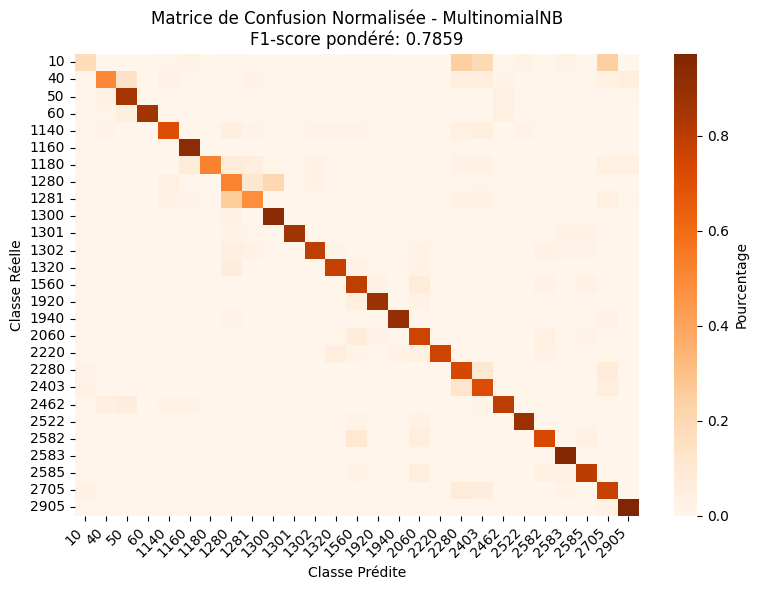


               precision    recall  f1-score   support

          10       0.46      0.18      0.26       307
          40       0.81      0.50      0.62       224
          50       0.75      0.86      0.80       245
          60       0.97      0.87      0.92       138
        1140       0.63      0.71      0.67       195
        1160       0.91      0.93      0.92       304
        1180       0.75      0.52      0.62        69
        1280       0.62      0.52      0.56       702
        1281       0.51      0.48      0.50       293
        1300       0.79      0.94      0.86       718
        1301       0.97      0.87      0.92       150
        1302       0.84      0.79      0.81       440
        1320       0.83      0.78      0.80       511
        1560       0.76      0.79      0.78       933
        1920       0.90      0.88      0.89       824
        1940       0.86      0.91      0.88       131
        2060       0.73      0.76      0.74       926
        2220       0.78  

In [ ]:
model = MultinomialNB(alpha=0.01)
ts = time.time()
model.fit(X_train, y_train.values.ravel())
print('Durée entraînement (s) : ',time.time()-ts)
evaluate(model)

## Régression logistique

Durée entraînement (mn) :  2.2381682833035788


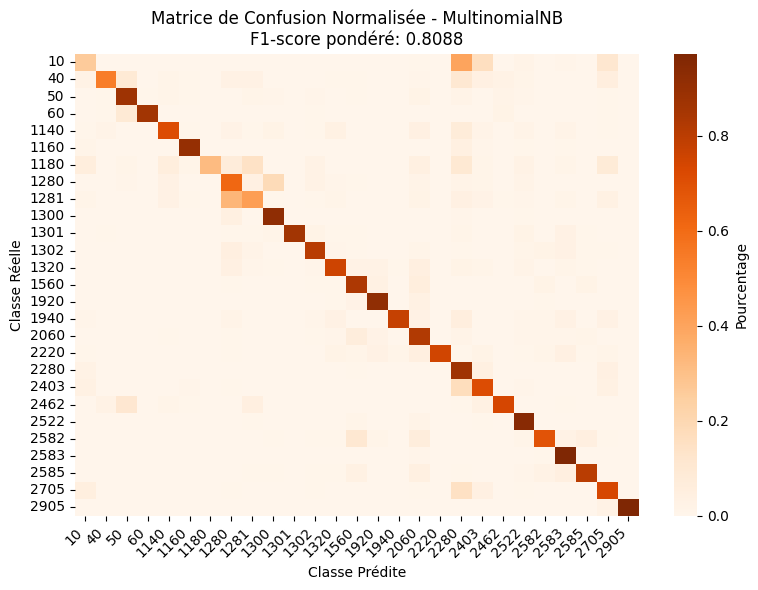


               precision    recall  f1-score   support

          10       0.46      0.26      0.33       307
          40       0.88      0.54      0.67       224
          50       0.78      0.88      0.82       245
          60       0.98      0.86      0.92       138
        1140       0.72      0.71      0.72       195
        1160       0.94      0.90      0.92       304
        1180       0.88      0.32      0.47        69
        1280       0.67      0.61      0.64       702
        1281       0.61      0.42      0.50       293
        1300       0.82      0.92      0.87       718
        1301       0.98      0.86      0.92       150
        1302       0.85      0.81      0.83       440
        1320       0.87      0.76      0.81       511
        1560       0.81      0.83      0.82       933
        1920       0.90      0.92      0.91       824
        1940       0.95      0.78      0.86       131
        2060       0.76      0.82      0.79       926
        2220       0.94  

In [ ]:
model = LogisticRegression(max_iter=1000)
ts = time.time()
model.fit(X_train, y_train.values.ravel())
print('Durée entraînement (mn) : ',(time.time()-ts)/60)
evaluate(model)

RandomSearchCV in progress ...
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Durée RandomSearchCV (mn) :  204.53908248345058

=== Résultats RandomSearchCV ===
Meilleurs paramètres: {'C': np.float64(4.682521523598518), 'l1_ratio': np.float64(0.473410314598384), 'multi_class': 'ovr', 'penalty': 'elasticnet', 'solver': 'saga'}
Meilleur score F1 pondéré (CV): 0.8128
Entraînement modèle optimisé ...
Modèle optimisé: LogisticRegression(C=np.float64(4.682521523598518),
                   l1_ratio=np.float64(0.473410314598384), max_iter=2000,
                   multi_class='ovr', penalty='elasticnet', random_state=42,
                   solver='saga')


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Durée entraînement (mn) :  45.36698419253032


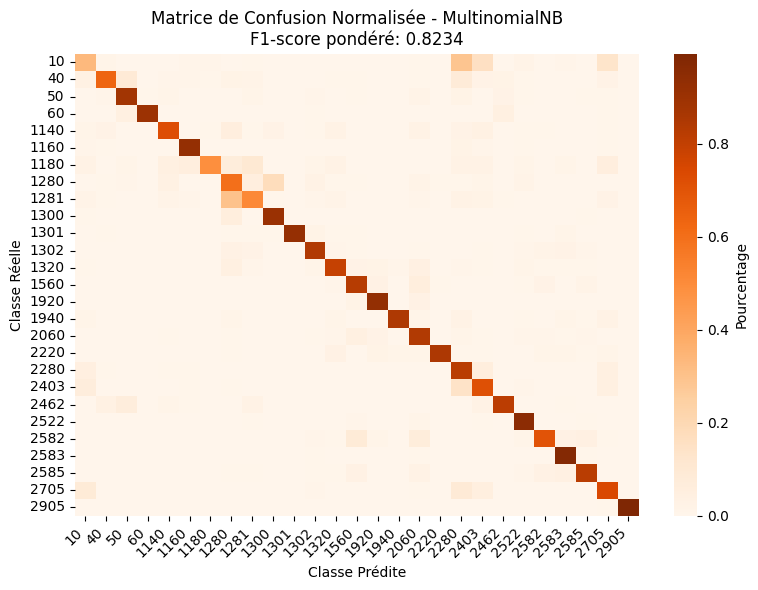


               precision    recall  f1-score   support

          10       0.40      0.33      0.36       307
          40       0.82      0.63      0.71       224
          50       0.82      0.88      0.85       245
          60       0.98      0.90      0.94       138
        1140       0.73      0.72      0.72       195
        1160       0.93      0.92      0.93       304
        1180       0.77      0.49      0.60        69
        1280       0.67      0.60      0.63       702
        1281       0.63      0.51      0.56       293
        1300       0.83      0.91      0.86       718
        1301       0.99      0.92      0.95       150
        1302       0.84      0.84      0.84       440
        1320       0.87      0.79      0.83       511
        1560       0.84      0.83      0.83       933
        1920       0.91      0.93      0.92       824
        1940       0.94      0.85      0.89       131
        2060       0.79      0.84      0.81       926
        2220       0.89  

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, loguniform

# Distribution de paramètres pour échantillonnage aléatoire
param_distributions = [
    {
        # Configuration L1 (Lasso)
        'penalty': ['l1'],
        'C': loguniform(0.01, 10),
        'solver': ['liblinear', 'saga'],
        'multi_class': ['ovr']
    },
    {
        # Configuration L2 (Ridge)
        'penalty': ['l2'],
        'C': loguniform(0.01, 10),
        'solver': ['lbfgs', 'liblinear', 'saga'],
        'multi_class': ['ovr', 'multinomial']
    },
    {
        # Configuration ElasticNet
        'penalty': ['elasticnet'],
        'C': loguniform(0.1, 5),
        'l1_ratio': uniform(0.1, 0.8),
        'solver': ['saga'],
        'multi_class': ['ovr', 'multinomial']
    }
]


# RandomSearchCV avec F1-score pondéré
random_search = RandomizedSearchCV(
    LogisticRegression(random_state=42, max_iter=2000),
    param_distributions,
    n_iter=10,
    cv=3,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1,
    random_state=42,
    return_train_score=True
)

ts = time.time()
print("RandomSearchCV in progress ...")
random_search.fit(X_train, y_train)     # prévoir de passer plutôt y_train.values.ravel()
print('Durée RandomSearchCV (mn) : ',(time.time()-ts)/60)

# Résultats du RandomSearchCV
print(f"\n=== Résultats RandomSearchCV ===")
print(f"Meilleurs paramètres: {random_search.best_params_}")
print(f"Meilleur score F1 pondéré (CV): {random_search.best_score_:.4f}")

best_params = random_search.best_params_.copy()

ts = time.time()
print("Entraînement modèle optimisé ...")
best_model = LogisticRegression(random_state=42, max_iter=2000, **best_params)
print(f"Modèle optimisé: {best_model}")
best_model.fit(X_train, y_train)     # prévoir de passer plutôt y_train.values.ravel()
print('Durée entraînement (mn) : ',(time.time()-ts)/60)
evaluate(best_model)


## SVM

Durée entraînement (s) :  1480.3095738887787


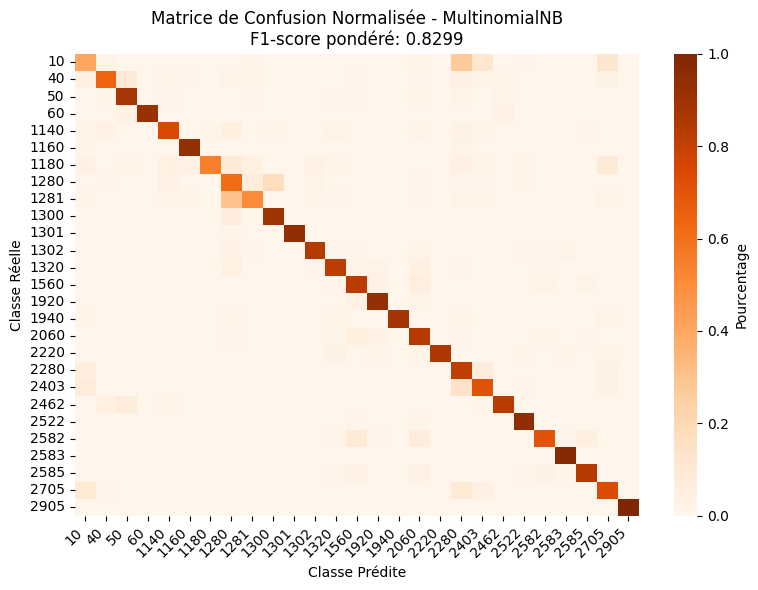


               precision    recall  f1-score   support

          10       0.40      0.40      0.40       307
          40       0.77      0.65      0.70       224
          50       0.82      0.87      0.84       245
          60       0.99      0.91      0.95       138
        1140       0.74      0.74      0.74       195
        1160       0.93      0.93      0.93       304
        1180       0.76      0.55      0.64        69
        1280       0.66      0.62      0.64       702
        1281       0.64      0.51      0.57       293
        1300       0.83      0.90      0.87       718
        1301       0.99      0.94      0.96       150
        1302       0.86      0.84      0.85       440
        1320       0.86      0.82      0.84       511
        1560       0.83      0.83      0.83       933
        1920       0.91      0.93      0.92       824
        1940       0.96      0.88      0.92       131
        2060       0.80      0.84      0.82       926
        2220       0.92  

In [ ]:
'''
2 GridSearchCV sont lancés successivement, le premier grossier, le second, resseré autour des meilleurs paramètres trouvés.

param_grid = {
    'C': [0.1, 10, 1000],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto'],
    'decision_function_shape': ['ovo', 'ovr'],  # One-vs-One ou One-vs-Rest
}
param_grid = {
    'C': [5, 7.5, 10, 12.5, 15],
    'kernel': ['rbf'],
    'gamma': ['scale', 0.01, 0.05, 0.1, 0.5],
    'decision_function_shape': ['ovo']
}

Enfin, un BayesSearchCV, plus efficace en terme de finalisation, autour des meilleurs paramètres dégagés par le précédent GridSearchCV
permet d'atteindre le meilleur score.
param_grid = {
    'C': Real(3, 7, prior='log-uniform'),
    'gamma': Real(0.3, 0.7, prior='log-uniform'),
    'kernel': Categorical(['rbf']),
    'decision_function_shape': Categorical(['ovo'])
}

Un modèle SVM est ensuite entraîné sur ces paramètres pour un F1-score pondéré à 83%.
Ces traitements successifs auront nécessité plusieurs dizaines d'heures de calculs !
'''

model = SVC(C=3.2049953149862804, decision_function_shape='ovo', gamma=0.43187695572094414, kernel='rbf', random_state=42)
ts = time.time()
model.fit(X_train, y_train.values.ravel())
print('Durée entraînement (mn) : ',(time.time()-ts)/60)
evaluate(model)
